In [64]:
import requests
from io import StringIO
import csv
import pandas as pd
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from collections import Iterable

# Supporting Functions

In [33]:
def import_data(ticker):
    """
    Imports data from Yahoo Finance and returns a dataframe.
    """
    stock_url = 'https://query1.finance.yahoo.com/v7/finance/download/{}?'
    params = {
        'range': '10y',
        'interval': '1d',
        'events': 'history',
        'includeAdjustedClose': 'true'
    }
    # using request library to import data from the yahoo finance url
    response = requests.get(stock_url.format(ticker), params=params)
    # convert response.text into a file object
    file = StringIO(response.text)
    # input into csv.reader. every row becomes a list
    reader = csv.reader(file)
    # convert into a nested list
    data = list(reader)

    return pd.DataFrame(data[1:],columns=data[0])


def flatten(lis):
    """
    Converts a nested list into a single list.
    """
    for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item


# def remove_null(data):
#     close_null = data[data['Close'] == 'null'].index
#     data = data.drop(close_null)
#     vol_null = data[data['Volume'] == 'null'].index
#     data = data.drop(vol_null)


def correct_dtypes(data):
    data['Close'] = data['Close'].astype(float)
    data['Date'] = pd.to_datetime(data['Date'])
    data['Volume'] = data['Volume'].astype(float)
    
    


In [34]:
# importing data
bitcoin_data = import_data('BTC-USD')
gold_data = import_data('GC=F')
sp_data = import_data('^GSPC')
crude_data = import_data('CL=F')
russel_data = import_data('^RUA')
nasdaq_data = import_data('NQ=F')
dj_data = import_data('^DJI')
ishares_data = import_data('IUSG')
file_path = Path("data/12_months_cpi.csv")
cpi_data = pd.read_csv(file_path)

In [35]:
cpi_data.head()

,Consumer Price Index,Unnamed: 1
0,(data is presented as percentage).,NaN
1,NaN,NaN
2,NaN,Canada
3,date,All-items
4,02-01-2021,1.1


# Data Cleaning

In [36]:
# selecting columns
russel_price = russel_data[['Date','Close']]
ishares_price = ishares_data[['Date','Close']]

nasdaq_vol = nasdaq_data[['Date','Close','Volume']]
gold_vol = gold_data[['Date','Close','Volume']]
bitcoin_vol = bitcoin_data[['Date','Close','Volume']]
dj_vol = dj_data[['Date','Close','Volume']]
crude_vol = crude_data[['Date','Close','Volume']]
sp_vol = sp_data[['Date','Close','Volume']]

In [37]:
# removing null values
russel_null = russel_price[russel_price['Close'] == 'null'].index
ishares_null = ishares_price[ishares_price['Close'] == 'null'].index
dj_vol_null = dj_vol[dj_vol['Volume'] == 'null'].index
crude_vol_null = crude_vol[crude_vol['Volume'] == 'null'].index
gold_vol_null = gold_vol[gold_vol['Volume'] == 'null'].index
bitcoin_vol_null = bitcoin_vol[bitcoin_vol['Volume'] == 'null'].index
nasdaq_vol_null = nasdaq_vol[nasdaq_vol['Volume'] == 'null'].index
sp_vol_null = sp_vol[sp_vol['Volume'] == 'null'].index

sp_vol = sp_vol.drop(sp_vol_null)
gold_vol = gold_vol.drop(gold_vol_null)
bitcoin_vol = bitcoin_vol.drop(bitcoin_vol_null)
crude_vol = crude_vol.drop(crude_vol_null)
dj_vol = dj_vol.drop(dj_vol_null)
nasdaq_vol = nasdaq_vol.drop(nasdaq_vol_null)
russel_price = russel_price.drop(russel_null)
ishares_price = ishares_price.drop(ishares_null)

# remove first 4 empty rows
cpi_data = cpi_data.iloc[4:]
cpi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 4 to 88
Data columns (total 2 columns):
Consumer Price Index    85 non-null object
Unnamed: 1              85 non-null object
dtypes: object(2)
memory usage: 1.4+ KB


In [38]:
# checking for null value rows
sp_vol.Volume.str.count("null").sum()

0

In [39]:
# renaming cpi_data columns
cpi_data.columns=['Date','cpi']

In [40]:
# change to correct dtypes
correct_dtypes(sp_vol)
correct_dtypes(gold_vol)
correct_dtypes(bitcoin_vol)
correct_dtypes(nasdaq_vol)
correct_dtypes(crude_vol)
correct_dtypes(dj_vol)
russel_price['Close'] = russel_price['Close'].astype(float)
russel_price['Date'] = pd.to_datetime(russel_price['Date'])
ishares_price['Close'] = ishares_price['Close'].astype(float)
ishares_price['Date'] = pd.to_datetime(ishares_price['Date'])
cpi_data['cpi'] = cpi_data['cpi'].astype(float)
cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])

In [41]:
russel_price = russel_price[['Date','Close']]
nasdaq_price = nasdaq_vol[['Date','Close']]
sp_price = sp_vol[['Date','Close']]
bitcoin_price = bitcoin_vol[['Date','Close']]
gold_price = gold_vol[['Date','Close']]

In [42]:
# daily returns
gold_price = gold_price.set_index('Date')
bitcoin_price = bitcoin_price.set_index('Date')
bitcoin_returns=bitcoin_price.pct_change().reset_index()
gold_returns=gold_price.pct_change().reset_index()

In [43]:
# merging dataframes
join_markets = pd.merge(bitcoin_price,sp_price,on='Date').merge(
    nasdaq_price,on='Date').set_index('Date')
join_prices = pd.merge(gold_price,bitcoin_price,on='Date').reset_index()
join_returns = pd.merge(gold_returns,bitcoin_returns,on='Date')
join_sp = pd.merge(bitcoin_price,sp_price,on='Date')
join_ishares = pd.merge(bitcoin_price,ishares_price, on='Date').set_index('Date')
join_bubble = pd.merge(bitcoin_vol,gold_vol,on='Date').merge(sp_vol,on='Date').merge(
    nasdaq_vol,on='Date').merge(crude_vol,on='Date').merge(dj_vol,on='Date')

In [44]:
join_bubble.head()

,Date,Close_x,Volume_x,Close_y,Volume_y,Close_x,Volume_x,Close_y,Volume_y,Close_x,Volume_x,Close_y,Volume_y
0,2014-09-17,457.334015,21056800.0,1234.400024,10.0,2001.569946,3.209420e+09,4072.50,68884.0,94.419998,305832.0,17156.849609,87810000.0
1,2014-09-18,424.440002,34483200.0,1225.699951,5.0,2011.359985,3.235340e+09,4103.75,33223.0,93.070000,170772.0,17265.990234,85300000.0
2,2014-09-19,394.795990,37919700.0,1215.300049,4.0,2010.400024,4.880220e+09,4118.50,279619.0,92.410004,92780.0,17279.740234,349620000.0
3,2014-09-22,402.152008,24127600.0,1216.800049,7.0,1994.290039,3.349670e+09,4052.75,295630.0,91.519997,229232.0,17172.679688,74300000.0
4,2014-09-23,435.790985,45099500.0,1221.000000,5.0,1982.770020,3.279350e+09,4037.00,276929.0,91.559998,247770.0,17055.869141,77090000.0


In [45]:
# rename columns of merged dataframes
join_prices.columns=['date','gold','bitcoin']
join_returns.columns=['date','gold returns','bitcoin returns']
join_ishares.columns=['bitcoin','ishares']
join_bubble.columns=['Date','bitcoin price','bitcoin volume','gold price','gold volume',
                     'sp price','sp volume','nasdaq price','nasdaq volume','crude price',
                     'crude volume', 'dj price','dj volume']


---

# What is Bitcoin's comparison with traditional asset classes based on their returns, volatility, and volume in the the past 5 years?

In [46]:
# 5 year period
years5 = (join_bubble['Date'] > '2015-03-1') & (join_bubble['Date'] <= '2020-03-01')
join_bubble = join_bubble[years5]

In [47]:
join_bubble_vol = join_bubble[['Date','bitcoin volume','gold volume','sp volume',
                               'nasdaq volume','crude volume','dj volume']]
join_bubble_vol.head()

,Date,bitcoin volume,gold volume,sp volume,nasdaq volume,crude volume,dj volume
111,2015-03-02,40465700.0,124.0,3.409490e+09,185330.0,427177.0,89790000.0
112,2015-03-03,50461300.0,51.0,3.262300e+09,198589.0,370597.0,83830000.0
113,2015-03-04,41383000.0,27.0,3.421110e+09,210995.0,463989.0,80900000.0
114,2015-03-05,41302400.0,29.0,3.103030e+09,185176.0,370953.0,75840000.0
115,2015-03-06,28918900.0,168.0,3.853570e+09,296605.0,406840.0,113350000.0


In [48]:
# calculate average volume
join_bubble_vol.set_index('Date',inplace=True)
avg_vol = join_bubble_vol.mean()
average_volume = avg_vol.tolist()

In [49]:
join_bubble_price = join_bubble[['Date','bitcoin price','gold price','sp price',
                               'nasdaq price','crude price','dj price']]
join_bubble_price = join_bubble_price.set_index('Date')
join_bubble_price = join_bubble_price.reset_index()
join_bubble_returns = join_bubble_price.iloc[[0,1247]]
join_bubble_returns.head()

,Date,bitcoin price,gold price,sp price,nasdaq price,crude price,dj price
0,2015-03-02,275.670013,1207.699951,2117.389893,4477.0,49.590000,18288.630859
1247,2020-02-28,8672.455078,1564.099976,2954.219971,8454.0,44.759998,25409.359375


In [50]:
# calculate 5 year returns
join_bubble_returns = join_bubble_returns.set_index('Date')
join_bubble_5returns = join_bubble_returns.pct_change()
returns5 = join_bubble_5returns.iloc[1:].values
returns5 = returns5.tolist()
return_5yrs = list(flatten(returns5))

In [51]:
# calculate average volatility
join_bubble_price = join_bubble_price.set_index('Date')
join_bubble_d_returns = join_bubble_price.pct_change()
join_volatility = join_bubble_d_returns.std() * np.sqrt(252)
join_volatility = join_volatility.tolist()

In [52]:
# create dataframe for bubble chart
Name = ['Bitcoin' , 'Gold', 'SP500' , 'NASDAQ', 'Crude', 'DowJ']
dataframe = pd.DataFrame({"Returns_5yr":return_5yrs, "Avg_volume":average_volume, "Average_volatility":join_volatility, "Name":Name})
dataframe

,Returns_5yr,Avg_volume,Average_volatility,Name
0,30.459552,6.306042e+09,0.704948,Bitcoin
1,0.295106,6.183330e+03,0.129616,Gold
2,0.395218,3.645957e+09,0.134879,SP500
3,0.888318,3.348129e+05,0.170625,NASDAQ
4,-0.097399,5.679619e+05,0.365199,Crude
5,0.389353,2.419225e+08,0.136139,DowJ


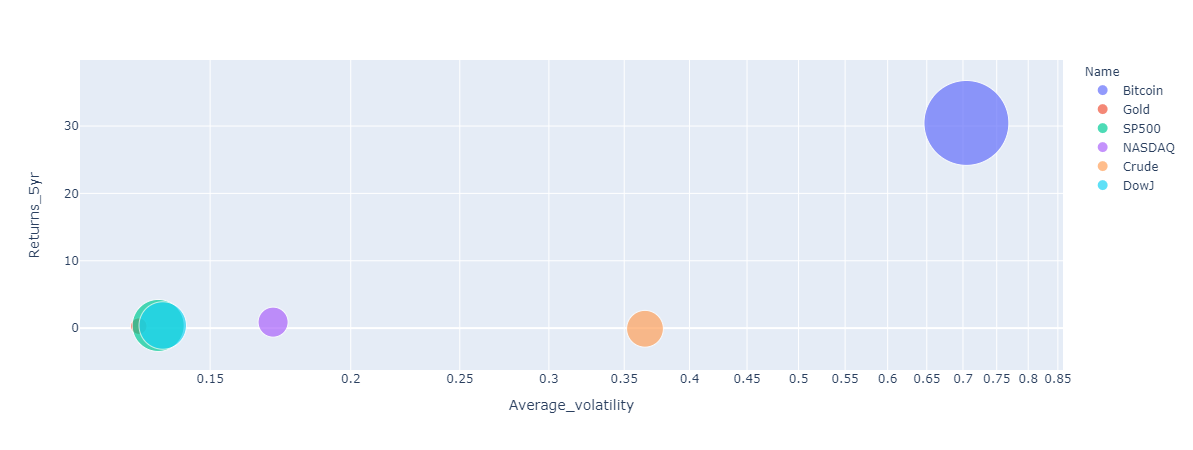

In [53]:
fig = px.scatter(dataframe, x="Average_volatility", y="Returns_5yr",
#                    size="Avg_volume", 
#                  bubble sizes were rescaled so that they appear on the graph
                 size = [80, 3, 30, 10, 15, 25],
                 color="Name",
                 hover_name= "Returns_5yr", log_x=True, size_max=60)

fig.show()

---

# What is Bitcoin’s growth prospect? And is it a viable investment?

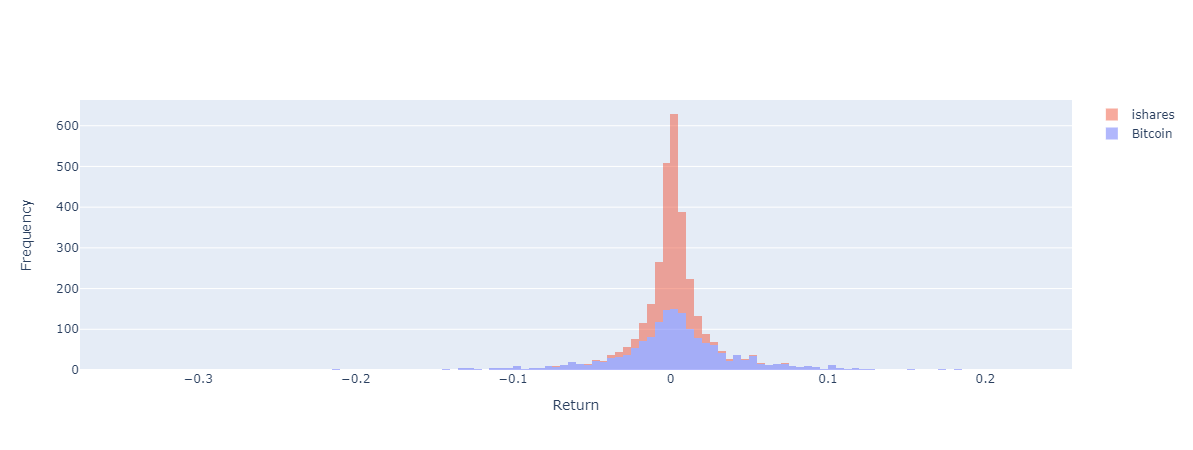

In [68]:
# bitcoin vs ishares ETF returns Histogram 

join_ishares_returns = join_ishares.pct_change()
fig = go.Figure()
fig.add_trace(go.Histogram(x=join_ishares_returns['bitcoin'],name='Bitcoin'))
fig.add_trace(go.Histogram(x=join_ishares_returns['ishares'],name='ishares'))
fig

# The two histograms are drawn on top of another
fig.update_layout(barmode='stack',xaxis_title_text='Return',yaxis_title_text='Frequency')
fig.update_traces(opacity=0.5)
fig.show()


---

# Can Bitcoin be described as Digital Gold?

In [55]:
# bitcoin vs gold returns line chart
join_gold = join_returns.set_index('date')
rolling_volatility = join_gold.rolling(window=252).std() * np.sqrt(252)

rolling_volatility.hvplot(ylabel='Rolling Volatility')

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [56]:
# bitcoin gold correlation
gold_btc_corr = join_gold.corr()
gold_btc_corr

,gold returns,bitcoin returns
gold returns,1.000000,0.099432
bitcoin returns,0.099432,1.000000


---

# How does a new asset/asset class stack up against traditional markets? Are there any relationships?

In [57]:
# price chart
join_markets.columns=['bitcoin','russel','nasdaq']
join_markets.hvplot(ylabel='Price')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

---

# How does bitcoin perform during inflation or deflation? CPI Index monthly return % change vs Bitcoin monthly return % change?

In [58]:
bitcoin_price.reset_index(inplace=True)
join_cpi_bitcoin = pd.merge(cpi_data,bitcoin_price,on='Date')
join_cpi_bitcoin.sort_values(by=['Date'],inplace=True)
join_cpi_bitcoin.set_index('Date',inplace=True)
join_cpi_bitcoin['Close'] = join_cpi_bitcoin['Close'].pct_change() * 100

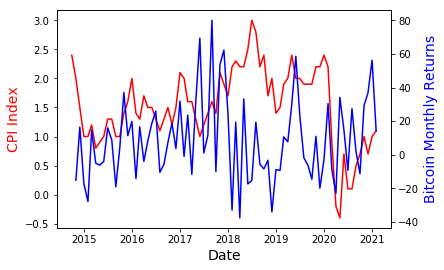

In [59]:
# bitcoin monthly returns vs cpi 
join_cpi_bitcoin = join_cpi_bitcoin.reset_index()
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
ax.plot(join_cpi_bitcoin['Date'],join_cpi_bitcoin['cpi'] , color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("CPI Index",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(join_cpi_bitcoin['Date'],join_cpi_bitcoin['Close'] , color="blue")
ax2.set_ylabel("Bitcoin Monthly Returns",color="blue",fontsize=14)

plt.show()
fig.savefig('cpi_vs_bitcoin.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [60]:
# bitcoin cpi covariance
covariance = join_cpi_bitcoin['cpi'].cov(join_cpi_bitcoin['Close'])
covariance

-0.5377011002254138

In [61]:
# save dataframes into csv files
dataframe.to_csv('data/bubble_data.csv')
join_cpi_bitcoin.to_csv('data/cpi_bitcoin_data.csv')
join_markets.to_csv('data/price_data.csv')
join_gold.to_csv('data/rolling_volatility_data.csv')
join_ishares_returns.to_csv('data/ishares_bitcoin_data.csv')